# Bank of England, ONS, & House Price Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm
from scipy.stats import linregress
import requests
import io
import os
from pathlib import Path
import numpy as np

DATA_DIR = "data"
PLOT_DIR = "plots"

In [2]:
def get_boe_data(
    name: str,
    codes: str,
    start_date: str,
    end_date: str = "",
) -> pd.DataFrame:
    """Return DataFrame with requested BoE data."""

    today = date.today()
    filename = name + "_" + today.strftime("%Y%m%d") + ".pkl"
    filename = os.path.join(DATA_DIR, filename)

    if Path(filename).is_file():  # already fetched
        return pd.read_pickle(filename)

    url = "http://www.bankofengland.co.uk/boeapps/iadb/fromshowcolumns.asp?csv.x=yes"

    params = {
        "Datefrom": start_date,
        "Dateto": end_date if end_date != "" else today.strftime("%d/%b/%Y"),
        "SeriesCodes": codes,
        "CSVF": "TN",
        "UsingCodes": "Y",
        "VPD": "Y",
        "VFD": "N",
    }

    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/54.0.2840.90 "
        "Safari/537.36"
    }

    response = requests.get(url, params=params, headers=headers)
    print(response.status_code)
    # print(response.url)
    # print(response.content)
    df_boe = pd.read_csv(io.BytesIO(response.content))
    df_boe["DATE"] = pd.to_datetime(df_boe["DATE"], format="%d %b %Y")
    df_boe.to_pickle(filename)
    return df_boe

In [3]:
def get_ons_data(name: str = "cpih") -> pd.DataFrame:
    """Return DataFrame with requested ONS data.

    Currently hard coded for CPIH.
    """

    today = date.today()
    filename = name + "_" + today.strftime("%Y%m%d") + ".pkl"
    filename = os.path.join(DATA_DIR, filename)

    if Path(filename).is_file():  # already fetched
        return pd.read_pickle(filename)

    url = "https://api.beta.ons.gov.uk/v1/datasets/cpih01/editions/time-series/versions/53/observations"
    params = {
        "time": "*",
        "geography": "K02000001",
        "aggregate": "CP00",
    }

    response = requests.get(url, params=params)
    print("Status Code:", response.status_code)
    # print("URL Requested:", response.url)

    results = response.json()
    # print(results)
    summary = []
    for observation in results.get("observations"):
        ident = observation.get("dimensions").get("Time").get("id")
        summary.append({"id": ident, "observation": observation.get("observation")})
    df_ons = pd.DataFrame(summary)

    # hard set for CPIH
    df_ons.columns = ["Date", "CPIH"]
    df_ons["Date"] = pd.to_datetime(df_ons["Date"], format="%b-%y")
    df_ons["CPIH"] = df_ons["CPIH"].astype("float64")
    df_ons.to_pickle(filename)
    return df_ons

In [4]:
def get_ons_unemployment() -> pd.DataFrame:
    """Return DataFrame with ONS unemployment data.

    Aged 16 and over, seasonally adjusted.
    """

    today = date.today()
    filename = "unemployment_" + today.strftime("%Y%m%d") + ".csv"
    filename = os.path.join(DATA_DIR, filename)

    if Path(filename).is_file():  # already fetched
        return pd.read_csv(filename)

    url = "https://www.ons.gov.uk/generator?format=csv&uri=/employmentandlabourmarket/peoplenotinwork/unemployment/timeseries/mgsx/lms"
    response = requests.get(url)
    if response.status_code == 200:
        df = pd.read_csv(io.StringIO(response.text))
        df = df.iloc[275:]  # drop first rows
        df.columns = ["Date", "Unemployment"]
        df["Date"] = pd.to_datetime(df["Date"], format="%Y %b")
        df = df.sort_values(by="Date")
        df["Month_Year"] = df["Date"].dt.strftime("%b %y")
        df.to_csv(filename, index=False)
        print(f"File successfully downloaded as {filename}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")
    return pd.read_csv(filename)


df_unemp = get_ons_unemployment()

In [5]:
def pound_formatter(x, pos) -> str:
    """Return a £ formatted string."""
    if x >= 1_000_000_000_000:  # trillions
        return f"£{x / 1_000_000_000_000:.2f} tn"
    elif x >= 1_000_000_000:  # billions
        return f"£{x / 1_000_000_000:.1f} bn"
    elif x >= 1_000_000:  # millions
        return f"£{x / 1_000_000:.1f} mn"
    elif x >= 1_000:  # thousands
        return f"£{x / 1_000:.1f}k"
    else:
        return f"£{x:,.0f}"

## HMLR Sales Data

In [6]:
def get_hmlr_data() -> pd.DataFrame:
    """Return DataFrame with HMRL sales data.

    Currently hard set to December 2024.
    """
    today = date.today()
    filename = "hmlr_" + today.strftime("%Y%m%d") + ".csv"
    filename = os.path.join(DATA_DIR, filename)

    if Path(filename).is_file():  # already fetched
        return pd.read_csv(filename)

    url = "https://publicdata.landregistry.gov.uk/market-trend-data/house-price-index-data/Cash-mortgage-sales-2024-10.csv"
    response = requests.get(url, verify=False)
    with open(filename, "wb") as file:
        file.write(response.content)
    return pd.read_csv(filename)


df_hmlr = get_hmlr_data()
df_hmlr = df_hmlr[df_hmlr["Region_Name"] == "Great Britain"]
df_hmlr["Date"] = pd.to_datetime(df_hmlr["Date"], format="%Y-%m-%d")
df_hmlr = df_hmlr.sort_values(by="Date")
df_hmlr["Month_Year"] = df_hmlr["Date"].dt.strftime("%b %y")
df_hmlr["Percent_Cash"] = (
    df_hmlr["Cash_Sales_Volume"]
    / (df_hmlr["Cash_Sales_Volume"] + df_hmlr["Mortgage_Sales_Volume"])
    * 100
)

## Rightmove HPI

In [7]:
def get_rightmove_data() -> pd.DataFrame:
    """Return DataFrame with Rightmove house prices."""
    filename = "rightmove_hpi.csv"
    filename = os.path.join(DATA_DIR, filename)
    return pd.read_csv(filename)


df_rm = get_rightmove_data()
df_rm.columns = ["Date", "Price"]
df_rm["Date"] = pd.to_datetime(df_rm["Date"], format="%b %y")
df_rm = df_rm.sort_values(by="Date")
df_rm["Month_Year"] = df_rm["Date"].dt.strftime("%b %y")
last_date = df_rm["Date"].max().strftime("%d %b %y")
print(last_date)

01 Dec 24


## Nationwide HPI

In [8]:
def get_nationwide_data() -> pd.DataFrame:
    """Return DataFrame with Nationwide house prices."""

    today = date.today()
    filename = "nationwide_" + today.strftime("%Y%m%d") + ".xlsx"
    filename = os.path.join(DATA_DIR, filename)

    if Path(filename).is_file():  # already fetched
        return pd.read_excel(filename)

    url = "https://www.nationwidehousepriceindex.co.uk/download/uk-monthly-index"
    response = requests.get(url)
    with open(filename, "wb") as file:
        file.write(response.content)
    return pd.read_excel(filename)


df_nw = get_nationwide_data()
df_nw.columns = ["Date", "Price"] + df_nw.columns[2:].tolist()
df_nw = df_nw.sort_values(by="Date")
df_nw["Month_Year"] = df_nw["Date"].dt.strftime("%b %y")
df_nw = df_nw[df_nw["Date"] >= "2000-01-01"]
last_date = df_nw["Date"].max().strftime("%d %b %y")
print(last_date)

01 Nov 24


/home/unknown/Documents/houses/econ/venv/lib/python3.12/site-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: Monthly!$A:$F.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


## Halifax HPI

In [9]:
def get_halifax_data() -> pd.DataFrame:
    """Return DataFrame with Halifax house prices."""
    filename = "halifax_hpi.csv"
    filename = os.path.join(DATA_DIR, filename)
    return pd.read_csv(filename)


df_hal = get_halifax_data()
df_hal.columns = ["Date", "Price"]
df_hal["Date"] = pd.to_datetime(df_hal["Date"], format="%b %y")
df_hal = df_hal.sort_values(by="Date")
df_hal["Month_Year"] = df_hal["Date"].dt.strftime("%b %y")
df_hal = df_hal[df_hal["Date"] >= "2000-01-01"]
last_date = df_hal["Date"].max().strftime("%d %b %y")
print(last_date)

01 Nov 24


## Zoopla HPI

Note that prior to 2023-06 the numbers are interpolated from the graph https://reports.hometrack.com/uk/insight/uk-house-price-index/

In [10]:
def get_zoopla_data() -> pd.DataFrame:
    """Return DataFrame with Zoopla house prices."""
    filename = "zoopla_hpi.csv"
    filename = os.path.join(DATA_DIR, filename)
    return pd.read_csv(filename)


df_zoo = get_zoopla_data()
df_zoo.columns = ["Date", "Price"]
df_zoo["Date"] = pd.to_datetime(df_zoo["Date"], format="%Y-%m")
df_zoo = df_zoo.sort_values(by="Date")
df_zoo["Month_Year"] = df_zoo["Date"].dt.strftime("%b %y")
df_zoo = df_zoo[df_zoo["Date"] >= "2000-01-01"]
last_date = df_zoo["Date"].max().strftime("%d %b %y")
print(last_date)

01 Nov 24


## ONS HPI

In [11]:
def get_ons_hpi(sheet: int) -> pd.DataFrame:
    """Return DataFrame with ONS house price index.

    Currently hard set to December 2024. Probably not the best dataset.
    """

    today = date.today()
    filename = "ons_hpi_" + today.strftime("%Y%m%d") + ".xlsx"
    filename = os.path.join(DATA_DIR, filename)

    if Path(filename).is_file():  # already fetched
        return pd.read_excel(filename, sheet_name=sheet)

    url = "https://www.ons.gov.uk/file?uri=/economy/inflationandpriceindices/datasets/ukhousepriceindexmonthlypricestatistics/18december2024/ukhousepriceindexmonthlypricestatistics.xlsx"
    response = requests.get(url)
    with open(filename, "wb") as file:
        file.write(response.content)
    return pd.read_excel(filename, sheet_name=sheet)

In [12]:
df_ons_hpi = get_ons_hpi(sheet=4)
df_ons_hpi = df_ons_hpi.iloc[2:]  # drop first two rows
df_ons_hpi = df_ons_hpi.iloc[:, :2]  # drop all but first two cols
df_ons_hpi.columns = ["Date", "Price"]
# Clean up dates and convert to datetime
df_ons_hpi["Date"] = (
    df_ons_hpi["Date"].str.replace(r"\s*\[.*?\]", "", regex=True).str.strip()
)
df_ons_hpi["Date"] = df_ons_hpi["Date"].apply(
    lambda x: x.replace("June", "Jun").replace("July", "Jul")
)
# convert to date object
df_ons_hpi["Date"] = pd.to_datetime(df_ons_hpi["Date"], format="%b %Y")
# add month year col
df_ons_hpi["Month_Year"] = df_ons_hpi["Date"].dt.strftime("%b %y")

In [13]:
df_ftb = get_ons_hpi(sheet=6)
df_ftb = df_ftb.iloc[4:]  # drop first five rows
df_ftb = df_ftb.drop(df_ftb.columns[[3, 4]], axis=1)
df_ftb.columns = ["Date", "FTB_Price", "FOO_Price", "FTB_Change", "FOO_Change"]
# Clean up dates and convert to datetime
df_ftb["Date"] = df_ftb["Date"].str.replace(r"\s*\[.*?\]", "", regex=True).str.strip()
df_ftb["Date"] = df_ftb["Date"].apply(
    lambda x: x.replace("June", "Jun").replace("July", "Jul")
)
# convert to date object
df_ftb["Date"] = pd.to_datetime(df_ftb["Date"], format="%b %Y")
# add month year col
df_ftb["Month_Year"] = df_ftb["Date"].dt.strftime("%b %y")
# clean up
df_ftb = df_ftb.replace("[x]", np.nan)
df_ftb = df_ftb[df_ftb["Date"] >= "2023-01-01"]
last_date = df_ftb["Date"].max().strftime("%d %b %y")
print(last_date)

01 Oct 24


/tmp/ipykernel_69665/2806823837.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ftb = df_ftb.replace("[x]", np.nan)


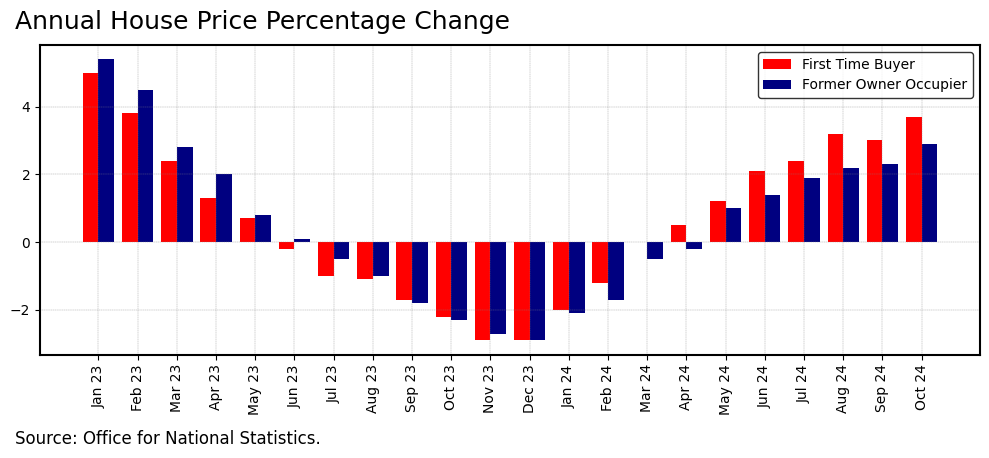

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_facecolor("white")

categories = df_ftb["Month_Year"]
bar_width = 0.4
x = np.arange(len(categories))
x2 = x + bar_width

ax.bar(x, df_ftb["FTB_Change"], width=bar_width, label="First Time Buyer", color="red")
ax.bar(
    x2,
    df_ftb["FOO_Change"],
    width=bar_width,
    label="Former Owner Occupier",
    color="navy",
)
ax.grid(True, color="grey", linestyle="--", linewidth=0.25)

ax.set_title("")
xticks = df_ftb["Month_Year"][::1]  # every nth date

plt.xticks(x + bar_width / 2, categories, rotation=90)

for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.02,
    0,
    "Source: Office for National Statistics.",
    ha="left",
    va="top",
    fontsize=12,
    color="black",
)

fig.text(
    0.02,
    1.05,
    "Annual House Price Percentage Change",
    ha="left",
    va="top",
    fontsize=18,
    color="black",
    # weight="bold",
)

plt.legend(facecolor="white", edgecolor="black", fontsize=10)
plt.tight_layout()

filename = os.path.join(PLOT_DIR, "ftb_foo_change.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

## Mortgages

In [15]:
df_mort = get_boe_data("mortgages", "LPMB3C2,LPMVTVU", "01/Jan/2000")
df_mort.columns = ["Date", "Total", "Number"]
df_mort["Price"] = df_mort["Total"] / df_mort["Number"] * 1000000
df_mort = df_mort.sort_values(by="Date")
df_mort["Month_Year"] = df_mort["Date"].dt.strftime("%b %y")
last_date = df_mort["Date"].max().strftime("%d %b %y")

## ONS HPI Revisions - Consistently Revised Down

In [16]:
def get_ons_revision_data() -> pd.DataFrame:
    """Return DataFrame with ONS revisions to house prices."""
    filename = "ons_estimates.csv"
    filename = os.path.join(DATA_DIR, filename)
    return pd.read_csv(filename)


df_rev = get_ons_revision_data()
df_rev.columns = ["Date", "New", "Orig"]
df_rev["Date"] = pd.to_datetime(df_rev["Date"], format="%b %Y")
df_rev = df_rev.sort_values(by="Date")
df_rev["Month_Year"] = df_rev["Date"].dt.strftime("%b %y")
df_rev = df_rev[df_rev["Date"] >= "2022-01-01"]

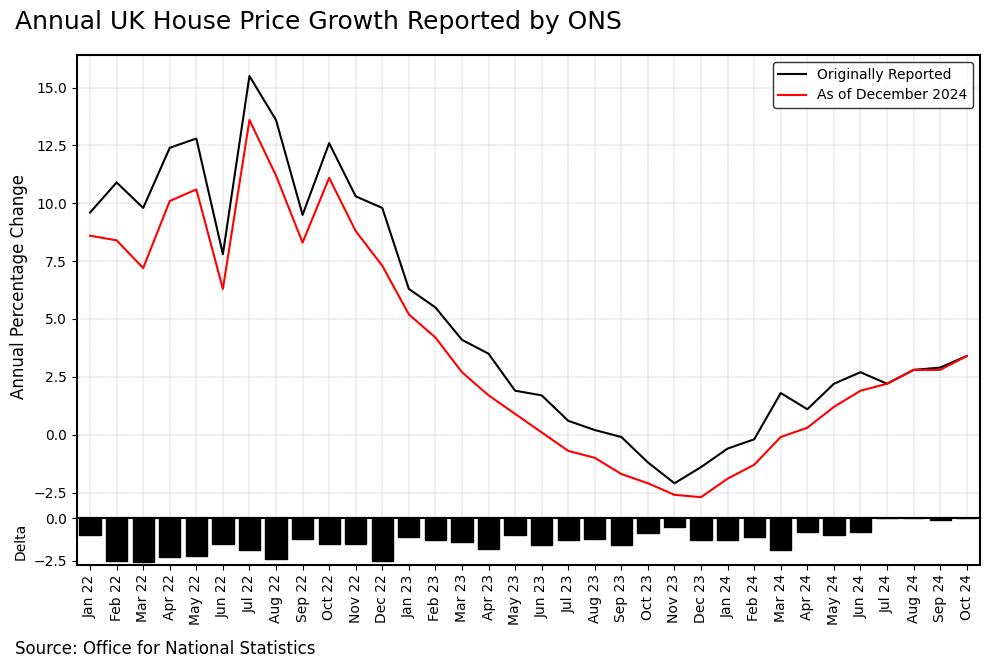

In [17]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 1, height_ratios=[10, 1], hspace=0)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.plot(
    df_rev["Month_Year"], df_rev["Orig"], label="Originally Reported", color="black"
)
ax1.plot(df_rev["Month_Year"], df_rev["New"], label="As of December 2024", color="red")
ax1.set_ylabel("Annual Percentage Change", fontsize="12")
ax1.grid(True, color="grey", linestyle="--", linewidth=0.25)

ax1.set_xticks(range(len(df_rev["Month_Year"])))
ax1.set_xticklabels([])  # no labels for ax1
ax1.set_xlim(-0.5, len(df_rev["Month_Year"]) - 0.5)  # align x-ticks

ax1.legend(facecolor="white", edgecolor="black", fontsize=10)

for spine in ax1.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

difference = df_rev["New"] - df_rev["Orig"]
ax2.bar(df_rev["Month_Year"], difference, color="black", edgecolor="black")
ax2.set_ylabel("Delta")

ax2.set_xticks(range(len(df_rev["Month_Year"])))
ax2.set_xticklabels(df_rev["Month_Year"], rotation=90, ha="center")
ax2.set_xlim(-0.5, len(df_rev["Month_Year"]) - 0.5)  # align x-ticks

for spine in ax2.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.02,
    0,
    "Source: Office for National Statistics",
    ha="left",
    va="top",
    fontsize=12,
    color="black",
)

fig.text(
    0.02,
    1.05,
    "Annual UK House Price Growth Reported by ONS",
    ha="left",
    va="top",
    fontsize=18,
    color="black",
)

plt.tight_layout()

filename = os.path.join(PLOT_DIR, "ons_revisions.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

## Total Secured Lending to Individuals

In [18]:
df_lend = get_boe_data("lending", "LPMVTXH", "01/Jan/2015")
df_lend.columns = ["Date", "Total"]
df_lend["Total"] = df_lend["Total"] * 1000000
df_lend = df_lend.sort_values(by="Date")
df_lend["Month_Year"] = df_lend["Date"].dt.strftime("%b %y")
last_date = df_lend["Date"].max().strftime("%d %b %y")

In [19]:
# Convert dates to numeric format for regression (e.g., as days since the first date)
df_lend["days"] = (df_lend["Date"] - df_lend["Date"].min()).dt.days

# Split the data based on the date
mid_date = "2020-01-31"  # pre-covid
end_date = "2022-11-30"  #
new_date = "2024-05-31"  # return to normal
df_normal = df_lend[df_lend["Date"] <= mid_date]
df_covid = df_lend[(df_lend["Date"] >= mid_date) & (df_lend["Date"] <= end_date)]
df_flat = df_lend[(df_lend["Date"] >= end_date) & (df_lend["Date"] <= new_date)]
df_new = df_lend[df_lend["Date"] >= new_date]

# fit linear regression on pre-covid
slope, intercept, rvalue, _, _ = linregress(df_normal["days"], df_normal["Total"])
precovid_r_squared = rvalue**2
df_lend["pre-covid"] = intercept + slope * df_lend["days"]

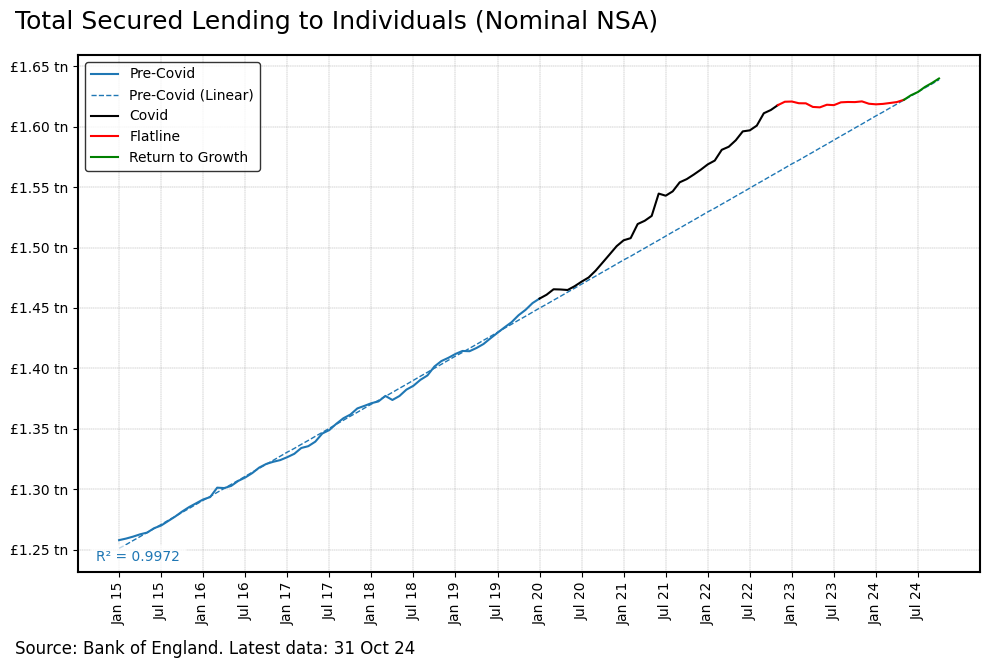

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_facecolor("white")

# pre-covid
(line1,) = ax.plot(df_normal["Month_Year"], df_normal["Total"], label="Pre-Covid")
color = line1.get_color()

ax.plot(
    df_lend["Month_Year"],
    df_lend["pre-covid"],
    label="Pre-Covid (Linear)",
    color=color,
    linestyle="--",
    linewidth=1,
)

# covid
ax.plot(df_covid["Month_Year"], df_covid["Total"], color="black", label="Covid")

# Flat
ax.plot(df_flat["Month_Year"], df_flat["Total"], color="red", label="Flatline")

# return to normal
ax.plot(df_new["Month_Year"], df_new["Total"], color="green", label="Return to Growth")

formatter = FuncFormatter(pound_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
ax.grid(True, color="grey", linestyle="--", linewidth=0.25)

xticks = df_lend["Month_Year"][::6]  # every nth date
plt.xticks(xticks, rotation=90)

for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.02,
    0,
    f"Source: Bank of England. Latest data: {last_date}",
    ha="left",
    va="top",
    fontsize=12,
    color="black",
)

fig.text(
    0.02,
    1.05,
    "Total Secured Lending to Individuals (Nominal NSA)",
    ha="left",
    va="top",
    fontsize=18,
    color="black",
)

# Add Pre-covid R-squared as a note in the bottom-left corner
plt.text(
    0.02,
    0.02,  # Position: from the bottom-left
    f"R² = {precovid_r_squared:.4f}",
    transform=plt.gca().transAxes,  # (0,0 is bottom-left)
    fontsize=10,
    color=color,
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
)

plt.legend(facecolor="white", edgecolor="black", fontsize=10)
plt.tight_layout()

filename = os.path.join(PLOT_DIR, "lending.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

## Nominal Savings

In [21]:
df_nsav = get_boe_data(
    "savings", "LPMB8S4,LPMVYWO,LPMZOD3,LPMZOD4,LPMZOD5", "01/Jan/2011"
)
names = ["ISA", "Cash", "No_Interest", "Interest", "Time"]
df_nsav.columns = ["Date"] + names
df_nsav["Total"] = df_nsav[names].sum(axis=1) * 1000000
df_nsav = df_nsav.sort_values(by="Date")
df_nsav["Month_Year"] = df_nsav["Date"].dt.strftime("%b %y")
last_date = df_nsav["Date"].max().strftime("%d %b %y")

In [22]:
# Add pre-covid linear regression
start_date = "2011-01-01"
end_date = "2020-02-29"

# Filter data for the regression fit
fit_data = df_nsav[(df_nsav["Date"] >= start_date) & (df_nsav["Date"] <= end_date)]

# Convert dates to numeric format for regression (e.g., as days since the first date)
df_nsav["days"] = (df_nsav["Date"] - df_nsav["Date"].min()).dt.days
fit_data = df_nsav[
    (df_nsav["Date"] >= start_date) & (df_nsav["Date"] <= end_date)
].copy()

# Fit linear regression
slope, intercept, rvalue, _, _ = linregress(fit_data["days"], fit_data["Total"])

# Calculate R-squared
precovid_r_squared = rvalue**2

# Project regression line over the full date range
df_nsav["pre-covid"] = intercept + slope * df_nsav["days"]

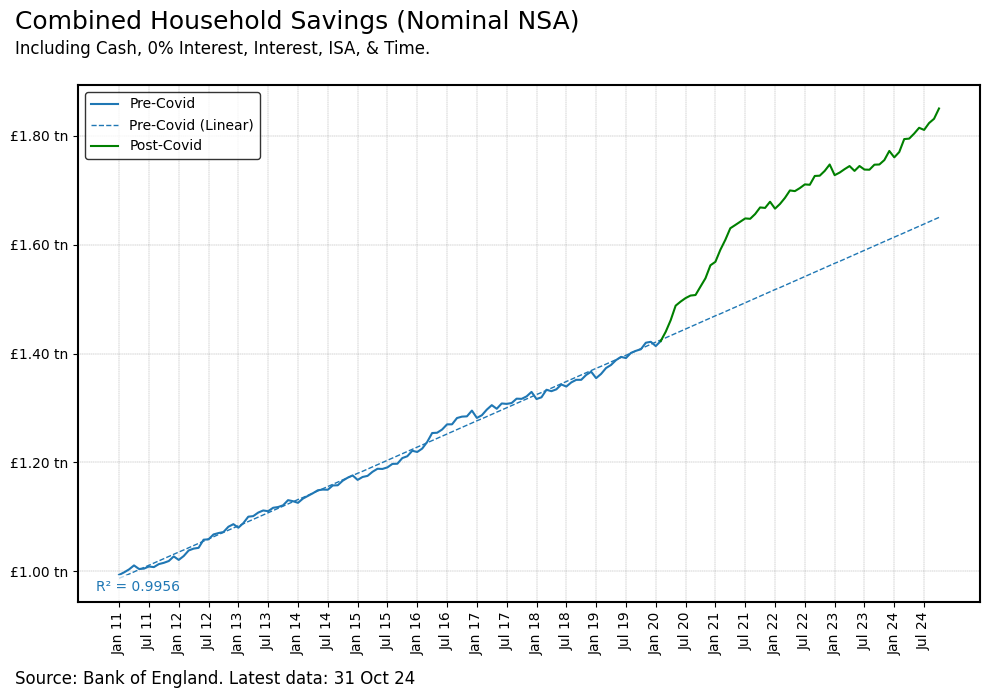

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor("white")

# Split the data into two parts based on the dates
df_nsav_precovid = df_nsav[df_nsav["Date"] <= end_date]
df_nsav_postcovid = df_nsav[df_nsav["Date"] >= end_date]

# Pre-covid
(line1,) = ax.plot(
    df_nsav_precovid["Month_Year"], df_nsav_precovid["Total"], label="Pre-Covid"
)
color = line1.get_color()

ax.plot(
    df_nsav["Month_Year"],
    df_nsav["pre-covid"],
    label="Pre-Covid (Linear)",
    color=color,
    linestyle="--",
    linewidth=1,
)

# Post-covid
ax.plot(
    df_nsav_postcovid["Month_Year"],
    df_nsav_postcovid["Total"],
    color="green",
    label="Post-Covid",
)

formatter = FuncFormatter(pound_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
ax.grid(True, color="grey", linestyle="--", linewidth=0.25)

xticks = df_nsav["Month_Year"][::6]  # every nth date
plt.xticks(xticks, rotation=90)
plt.tick_params(axis="x", labelsize=10)

# Set the spines (borders) to black
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.02,
    0,
    f"Source: Bank of England. Latest data: {last_date}",
    ha="left",
    va="top",
    fontsize=12,
    color="black",
)

fig.text(
    0.02,
    1.1,
    "Combined Household Savings (Nominal NSA)",
    ha="left",
    va="top",
    fontsize=18,
    color="black",
    # weight="bold",
)

fig.text(
    0.02,
    1.05,
    "Including Cash, 0% Interest, Interest, ISA, & Time.",
    ha="left",
    va="top",
    fontsize=12,
    color="black",
)

# Add R-squared as a note in the bottom-left corner
plt.text(
    0.02,
    0.02,  # Position: 2% from the bottom-left
    f"R² = {precovid_r_squared:.4f}",
    transform=plt.gca().transAxes,  # (0,0 is bottom-left)
    fontsize=10,
    color=color,
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
)

plt.legend(facecolor="white", edgecolor="black", fontsize=10)
plt.tight_layout()

filename = os.path.join(PLOT_DIR, "savings_nominal.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

## Get CPI Data

In [24]:
df_cpi = get_ons_data("cpih")
df_cpi["Month_Year"] = df_cpi["Date"].dt.strftime("%b %y")
df_cpi = df_cpi.sort_values(by="Date")

## Real Savings

In [25]:
df_rsav = df_nsav.merge(df_cpi[["Month_Year", "CPIH"]], on="Month_Year", how="left")
df_rsav["Real_Total"] = (df_rsav["Total"] / df_rsav["CPIH"]) * 100
df_rsav["Real_Total"] = df_rsav["Real_Total"].astype("float64")

new_date = "2023-09-30"

# Pre-covid
fit_data = df_rsav[(df_rsav["Date"] >= start_date) & (df_rsav["Date"] <= end_date)]
precovid_slope, precovid_intercept, rvalue, _, _ = linregress(
    fit_data["days"], fit_data["Real_Total"]
)
precovid_r_squared = rvalue**2
df_rsav["pre-covid-real"] = precovid_intercept + precovid_slope * df_rsav["days"]

# New normal
fit_data = df_rsav[(df_rsav["Date"] >= new_date)]
new_slope, new_intercept, rvalue, _, _ = linregress(
    fit_data["days"], fit_data["Real_Total"]
)
new_r_squared = rvalue**2
df_rsav["new-real"] = new_intercept + new_slope * df_rsav["days"]

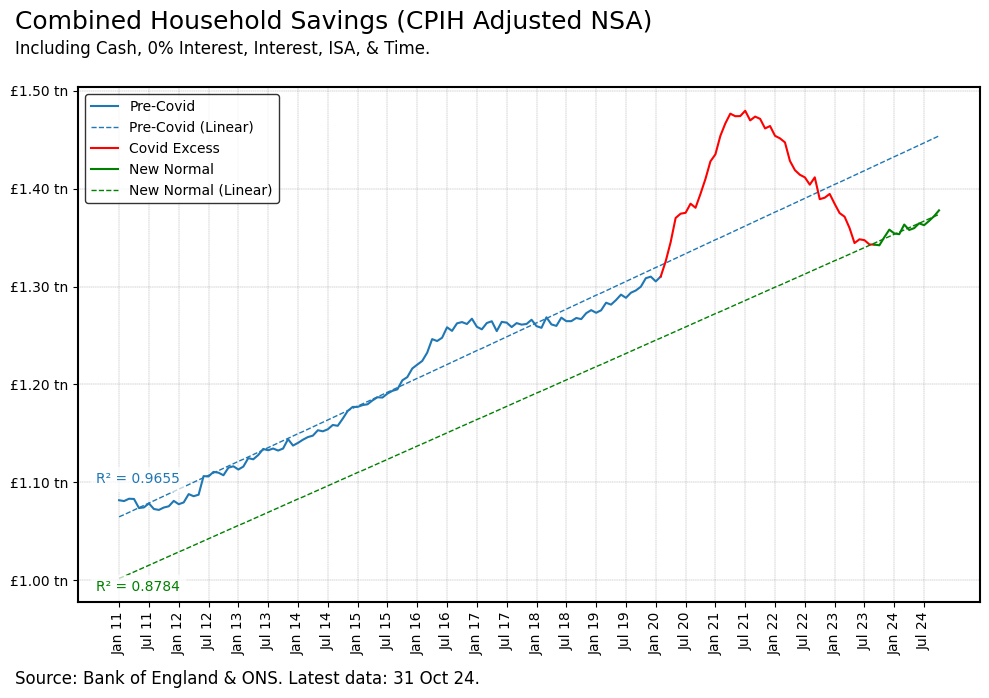

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor("white")

# Split the data based on the date
df_precovid = df_rsav[df_rsav["Date"] <= end_date]
df_covid = df_rsav[df_rsav["Date"] >= end_date]
df_new = df_covid[df_covid["Date"] >= new_date]
df_covid = df_covid[df_covid["Date"] <= new_date]

# Pre-covid
(line1,) = ax.plot(
    df_precovid["Month_Year"], df_precovid["Real_Total"], label="Pre-Covid"
)
color = line1.get_color()

ax.plot(
    df_rsav["Month_Year"],
    df_rsav["pre-covid-real"],
    label="Pre-Covid (Linear)",
    color=color,
    linestyle="--",
    linewidth=1,
)

# covid excess
ax.plot(
    df_covid["Month_Year"], df_covid["Real_Total"], color="red", label="Covid Excess"
)

# new normal
ax.plot(df_new["Month_Year"], df_new["Real_Total"], color="green", label="New Normal")

ax.plot(
    df_rsav["Month_Year"],
    df_rsav["new-real"],
    label="New Normal (Linear)",
    color="green",
    linestyle="--",
    linewidth=1,
)

formatter = FuncFormatter(pound_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
ax.grid(True, color="grey", linestyle="--", linewidth=0.25)

xticks = df_rsav["Month_Year"][::6]  # every nth date
plt.xticks(xticks, rotation=90)
plt.tick_params(axis="x", labelsize=10)

# Set the spines (borders) to black
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.02,
    0,
    f"Source: Bank of England & ONS. Latest data: {last_date}.",
    ha="left",
    va="top",
    fontsize=12,
    color="black",
)

fig.text(
    0.02,
    1.1,
    "Combined Household Savings (CPIH Adjusted NSA)",
    ha="left",
    va="top",
    fontsize=18,
    color="black",
    # weight="bold",
)

fig.text(
    0.02,
    1.05,
    "Including Cash, 0% Interest, Interest, ISA, & Time.",
    ha="left",
    va="top",
    fontsize=12,
    color="black",
)

# Add Pre-covid R-squared as a note in the bottom-left corner
plt.text(
    0.02,
    0.23,  # Position: from the bottom-left
    f"R² = {precovid_r_squared:.4f}",
    transform=plt.gca().transAxes,  # (0,0 is bottom-left)
    fontsize=10,
    color=color,
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
)
# Add New normal R-squared as a note in the bottom-left corner
plt.text(
    0.02,
    0.02,  # Position: from the bottom-left
    f"R² = {new_r_squared:.4f}",
    transform=plt.gca().transAxes,  # (0,0 is bottom-left)
    fontsize=10,
    color="green",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
)

plt.legend(facecolor="white", edgecolor="black", fontsize=10)
plt.tight_layout()

filename = os.path.join(PLOT_DIR, "savings_real.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

### No statistically significant difference in CPIH adjusted savings growth before and after

In [27]:
# Combine pre-COVID and New Normal data
df_new["Period"] = "New Normal"
df_combined = pd.concat([df_precovid, df_new])

# Encode the period as a binary variable
df_combined["Period_Binary"] = (df_combined["Period"] == "New Normal").astype(int)

# Define the independent variable (i.e., Date) and dependent variable
X = sm.add_constant(
    pd.DataFrame(
        {
            # Numeric representation of dates
            "Time": df_combined["Date"].factorize()[0],
            "Period_Binary": df_combined["Period_Binary"],
            "Interaction": df_combined["Date"].factorize()[0]
            * df_combined["Period_Binary"],
        }
    )
)
y = df_combined["Real_Total"]

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Real_Total   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1728.
Date:                Fri, 27 Dec 2024   Prob (F-statistic):           1.65e-98
Time:                        23:18:45   Log-Likelihood:                -3067.3
No. Observations:                 124   AIC:                             6143.
Df Residuals:                     120   BIC:                             6154.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.065e+12   2.58e+09    413.098

## Credit Card Debt

In [28]:
df_credit = get_boe_data("credit", "LPMVZRE", "01/Jan/2015")
df_credit.columns = ["Date", "Total"]
df_credit["Total"] = df_credit["Total"] * 1000000
df_credit = df_credit.sort_values(by="Date")
df_credit["Month_Year"] = df_credit["Date"].dt.strftime("%b %y")
last_date = df_credit["Date"].max().strftime("%d %b %y")

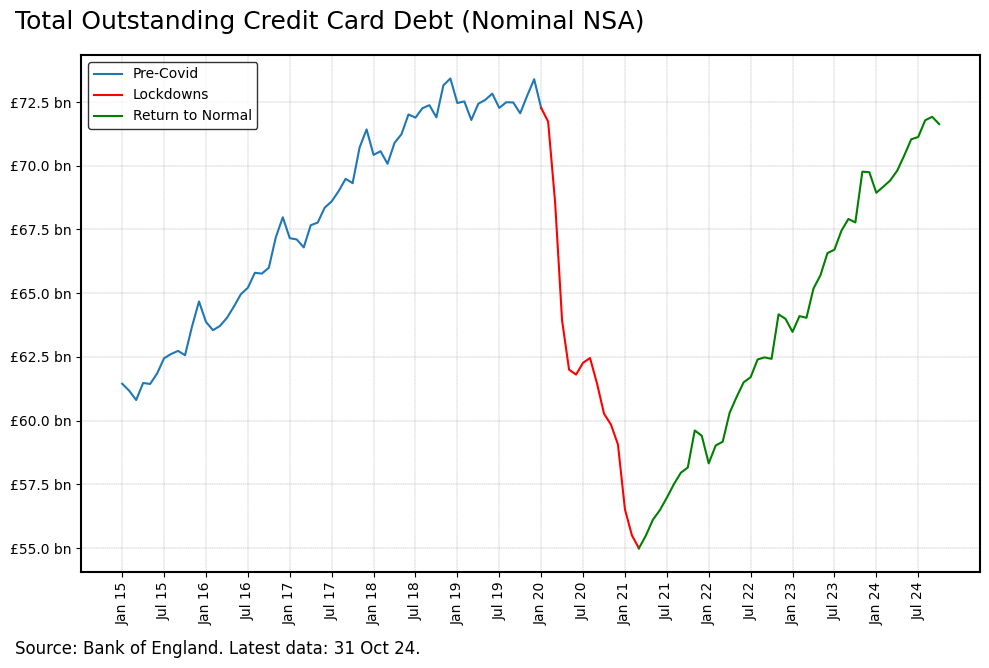

In [29]:
# Split the data based on the date
end_date = "2020-01-31"  # start of lockdowns
new_date = "2021-03-31"  # end of lockdowns
df_precovid = df_credit[df_credit["Date"] <= end_date]
df_covid = df_credit[df_credit["Date"] >= end_date]
df_new = df_covid[df_covid["Date"] >= new_date]
df_covid = df_covid[df_covid["Date"] <= new_date]

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_facecolor("white")

# Pre-covid
(line1,) = ax.plot(df_precovid["Month_Year"], df_precovid["Total"], label="Pre-Covid")
color = line1.get_color()

# lockdowns
ax.plot(df_covid["Month_Year"], df_covid["Total"], color="red", label="Lockdowns")

# return to normal
ax.plot(df_new["Month_Year"], df_new["Total"], color="green", label="Return to Normal")

formatter = FuncFormatter(pound_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
ax.grid(True, color="grey", linestyle="--", linewidth=0.25)

xticks = df_credit["Month_Year"][::6]  # every nth date
plt.xticks(xticks, rotation=90)

for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.02,
    0,
    f"Source: Bank of England. Latest data: {last_date}.",
    ha="left",
    va="top",
    fontsize=12,
    color="black",
)

fig.text(
    0.02,
    1.05,
    "Total Outstanding Credit Card Debt (Nominal NSA)",
    ha="left",
    va="top",
    fontsize=18,
    color="black",
)

plt.legend(facecolor="white", edgecolor="black", fontsize=10)
plt.tight_layout()

filename = os.path.join(PLOT_DIR, "credit.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

## Wages

In [30]:
def get_ons_wages(sheet: int) -> pd.DataFrame:
    """Return DataFrame with ONS wages.

    Currently hard set to December 2024.
    """

    today = date.today()
    filename = "ons_wages_" + today.strftime("%Y%m%d") + ".xlsx"
    filename = os.path.join(DATA_DIR, filename)

    if Path(filename).is_file():  # already fetched
        return pd.read_excel(filename, sheet_name=sheet)

    url = "https://www.ons.gov.uk/file?uri=/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/averageweeklyearningsearn01/current/earn01dec2024.xls"
    #    url = "https://www.ons.gov.uk/file?uri=/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/averageweeklyearningsbysectorearn02/current/earn02dec2024.xls"
    response = requests.get(url)
    with open(filename, "wb") as file:
        file.write(response.content)
    return pd.read_excel(filename, sheet_name=sheet)


df_wages = get_ons_wages(sheet=6)
df_wages = df_wages.iloc[
    8:305
]  # drop first few rows and clip the end (ADJUST THIS WITH UPDATED XLSX)
df_wages = df_wages.iloc[:, :2]  # drop all but first two cols
df_wages.columns = ["Date", "Wage"]
# convert to date object
df_wages["Date"] = pd.to_datetime(df_wages["Date"], format="%Y-%m-%d %H:%M:%S")
# add month year col
df_wages["Month_Year"] = df_wages["Date"].dt.strftime("%b %y")

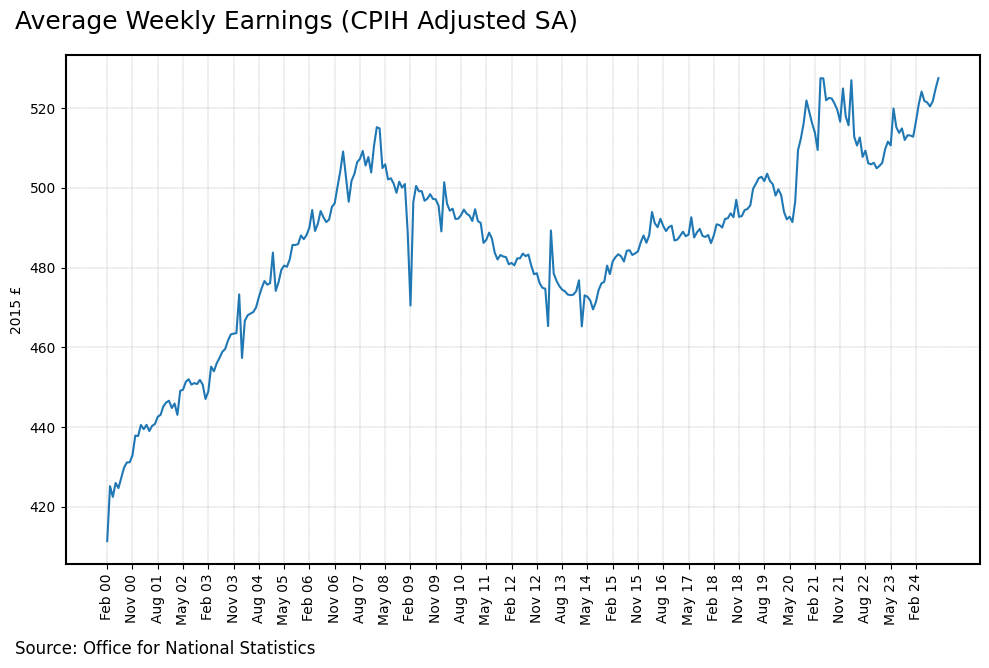

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor("white")
ax.plot(df_wages["Month_Year"], df_wages["Wage"])
ax.grid(True, color="grey", linestyle="--", linewidth=0.25)
xticks = df_wages["Month_Year"][::9]  # every nth date
plt.xticks(xticks, rotation=90)
ax.set_ylabel("2015 £")
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.02,
    0,
    "Source: Office for National Statistics",
    ha="left",
    va="top",
    fontsize=12,
    color="black",
)

fig.text(
    0.02,
    1.05,
    "Average Weekly Earnings (CPIH Adjusted SA)",
    ha="left",
    va="top",
    fontsize=18,
    color="black",
)

plt.tight_layout()

filename = os.path.join(PLOT_DIR, "wages.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

## Unemployment

In [32]:
def get_ons_unemployment(sheet: int) -> pd.DataFrame:
    """Return DataFrame with ONS unemployment.

    Currently hard set to December 2024.
    """

    today = date.today()
    filename = "ons_unemployment" + today.strftime("%Y%m%d") + ".xlsx"
    filename = os.path.join(DATA_DIR, filename)

    if Path(filename).is_file():  # already fetched
        return pd.read_excel(filename, sheet_name=sheet)

    url = "https://www.ons.gov.uk/file?uri=/employmentandlabourmarket/peoplenotinwork/unemployment/datasets/vacanciesandunemploymentvacs01/current/vacs01dec2024.xlsx"
    response = requests.get(url)
    with open(filename, "wb") as file:
        file.write(response.content)
    return pd.read_excel(filename, sheet_name=sheet)


df_vac = get_ons_unemployment(sheet=0)
df_vac = df_vac.iloc[
    6:287
]  # drop first few rows and clip the end (ADJUST THIS WITH UPDATED XLSX)
df_vac = df_vac.iloc[:, :5]  # drop cols
cols = ["Vacancies", "Unemployment", "Unemployed Per Vacancy"]
df_vac.columns = ["Date", "Revised"] + cols
# convert to numeric
df_vac[cols] = df_vac[cols].apply(pd.to_numeric, errors="coerce")

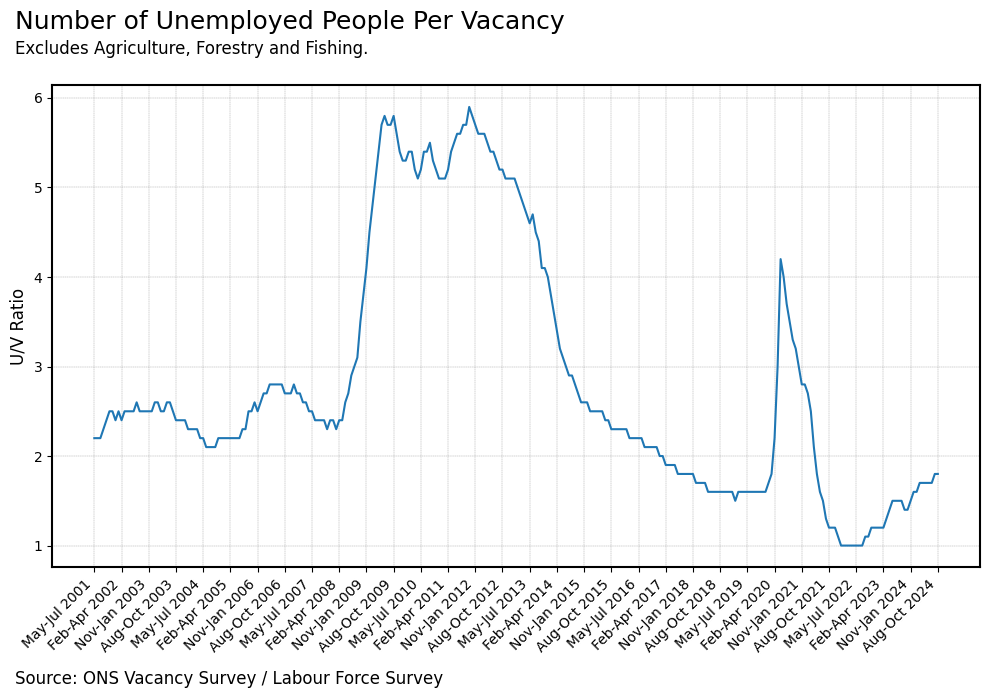

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor("white")
ax.plot(df_vac["Date"], df_vac["Unemployed Per Vacancy"])
ax.grid(True, color="grey", linestyle="--", linewidth=0.25)
xticks = df_vac["Date"][::9]  # every nth date
ax.set_ylabel("U/V Ratio", fontsize=12)
ax.set_xticks(ticks=xticks, labels=xticks, rotation=45, ha="right")

for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.02,
    0,
    "Source: ONS Vacancy Survey / Labour Force Survey",
    ha="left",
    va="top",
    fontsize=12,
    color="black",
)

fig.text(
    0.02,
    1.1,
    "Number of Unemployed People Per Vacancy",
    ha="left",
    va="top",
    fontsize=18,
    color="black",
)

fig.text(
    0.02,
    1.05,
    "Excludes Agriculture, Forestry and Fishing.",
    ha="left",
    va="top",
    fontsize=12,
    color="black",
)

plt.tight_layout()

filename = os.path.join(PLOT_DIR, "unemployment.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

## Interest Rates vs. House Prices

In [34]:
def get_boe_rate_data() -> pd.DataFrame:
    """Return DataFrame with BOE interest rates."""
    filename = "boe_rate.csv"
    filename = os.path.join(DATA_DIR, filename)
    return pd.read_csv(filename)


df_rate = get_boe_rate_data()
df_rate.columns = ["Date", "Rate"]
df_rate["Date"] = pd.to_datetime(df_rate["Date"], format="%d %b %y")
df_rate = df_rate.sort_values("Date", ascending=False)
df_rate["Month_Year"] = df_rate["Date"].dt.strftime("%b %y")

# Keep the latest entry for each month
df_rate = df_rate.loc[~df_rate["Date"].dt.to_period("M").duplicated()]

# Create a new DataFrame with all months
start_date = df_rate["Date"].min()
end_date = df_rate["Date"].max()

all_months = pd.date_range(start=start_date, end=end_date, freq="MS")
new_df = pd.DataFrame({"Date": all_months})
new_df["Month_Year"] = new_df["Date"].dt.strftime("%b %y")

# Merge with the original DataFrame
merged_df = new_df.merge(df_rate[["Month_Year", "Rate"]], on="Month_Year", how="left")

# Fill missing values with the previous value
merged_df["Rate"] = merged_df["Rate"].fillna(method="ffill")

df_rate = merged_df

/tmp/ipykernel_69665/2596072013.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df["Rate"] = merged_df["Rate"].fillna(method="ffill")


In [35]:
def get_cpi_annual_data() -> pd.DataFrame:
    """Return DataFrame with ONS CPIH rates."""
    filename = "cpih_annual.csv"
    filename = os.path.join(DATA_DIR, filename)
    return pd.read_csv(filename)


df_cpihy = get_cpi_annual_data()
df_cpihy.columns = ["Date", "CPIHA"]
df_cpihy["Date"] = pd.to_datetime(df_cpihy["Date"], format="%Y %b")
df_cpihy = df_cpihy.sort_values(by="Date")
df_cpihy["Month_Year"] = df_cpihy["Date"].dt.strftime("%b %y")

In [36]:
def get_rpi_annual_data() -> pd.DataFrame:
    """Return DataFrame with ONS RPI annual rates."""
    filename = "ons_rpi_annual.csv"
    filename = os.path.join(DATA_DIR, filename)
    return pd.read_csv(filename)


df_rpiy = get_rpi_annual_data()
df_rpiy.columns = ["Date", "RPIA"]
df_rpiy["Date"] = pd.to_datetime(df_rpiy["Date"], format="%Y %b")
df_rpiy = df_rpiy.sort_values(by="Date")
df_rpiy["Month_Year"] = df_rpiy["Date"].dt.strftime("%b %y")

In [37]:
df_nw = get_nationwide_data()
df_nw.columns = ["Date", "Price"] + df_nw.columns[2:].tolist()
df_nw = df_nw.iloc[:, :2]  # drop all but first two cols
df_nw = df_nw.sort_values(by="Date")
df_nw["Month_Year"] = df_nw["Date"].dt.strftime("%b %y")

/home/unknown/Documents/houses/econ/venv/lib/python3.12/site-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: Monthly!$A:$F.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


In [38]:
def get_ons_rpi_data() -> pd.DataFrame:
    """Return DataFrame with ONS retail price inflation."""
    filename = "ons_rpi.csv"
    filename = os.path.join(DATA_DIR, filename)
    return pd.read_csv(filename)


df_rpi = get_ons_rpi_data()
df_rpi.columns = ["Date", "RPI"]
df_rpi["Date"] = pd.to_datetime(df_rpi["Date"], format="%Y %b")
df_rpi = df_rpi.sort_values(by="Date")
df_rpi["Month_Year"] = df_rpi["Date"].dt.strftime("%b %y")

In [39]:
merged_df = df_nw.merge(df_rpi[["Month_Year", "RPI"]], on="Month_Year", how="left")
merged_df = merged_df.merge(
    df_cpihy[["Month_Year", "CPIHA"]], on="Month_Year", how="left"
)
merged_df = merged_df.merge(
    df_rate[["Month_Year", "Rate"]], on="Month_Year", how="left"
)
merged_df = merged_df.merge(df_cpi[["Month_Year", "CPIH"]], on="Month_Year", how="left")
merged_df = merged_df.merge(
    df_rpiy[["Month_Year", "RPIA"]], on="Month_Year", how="left"
)
merged_df = merged_df.merge(
    df_wages[["Month_Year", "Wage"]], on="Month_Year", how="left"
)

In [40]:
def normalise_column(df: pd.DataFrame, col_name: str) -> pd.Series:
    """
    Normalizes a column in a DataFrame so its minimum value is 0 and maximum is 1.
    """
    return (df[col_name] - df[col_name].min()) / (
        df[col_name].max() - df[col_name].min()
    )

In [41]:
# adjust house prices

mode = "CPIH"

if mode == "RPI":
    merged_df["Price"] = merged_df["Price"] / (
        merged_df["RPI"] / 390.9
    )  # Nov 2024 as 100
    merged_df["Rate"] = merged_df["Rate"] - merged_df["RPIA"]
elif mode == "CPIH":
    merged_df["Price"] = merged_df["Price"] / (
        merged_df["CPIH"] / 134.6
    )  # Nov 2024 at 100
    merged_df["Rate"] = merged_df["Rate"] - merged_df["CPIHA"]

# normalise
# merged_df["Normalized_Value"] = (merged_df["Value"] - merged_df["Value"].min()) / (merged_df["Value"].max() - merged_df["Value"].min())

cols = ["Price", "RPI", "CPIH", "Rate", "Wage"]

for col in cols:
    merged_df[col] = normalise_column(merged_df, col)


# merged_df['Price'] = merged_df['Price'] / merged_df['Price'].max()
# merged_df['RPI'] = merged_df['RPI'] / merged_df['RPI'].max()
# merged_df['CPIH'] = merged_df['CPIH'] / merged_df['CPIH'].max()
# merged_df['Rate'] = merged_df['Rate'] / merged_df['Rate'].max()
# merged_df['Wage'] = merged_df['Wage'] / merged_df['Wage'].max()

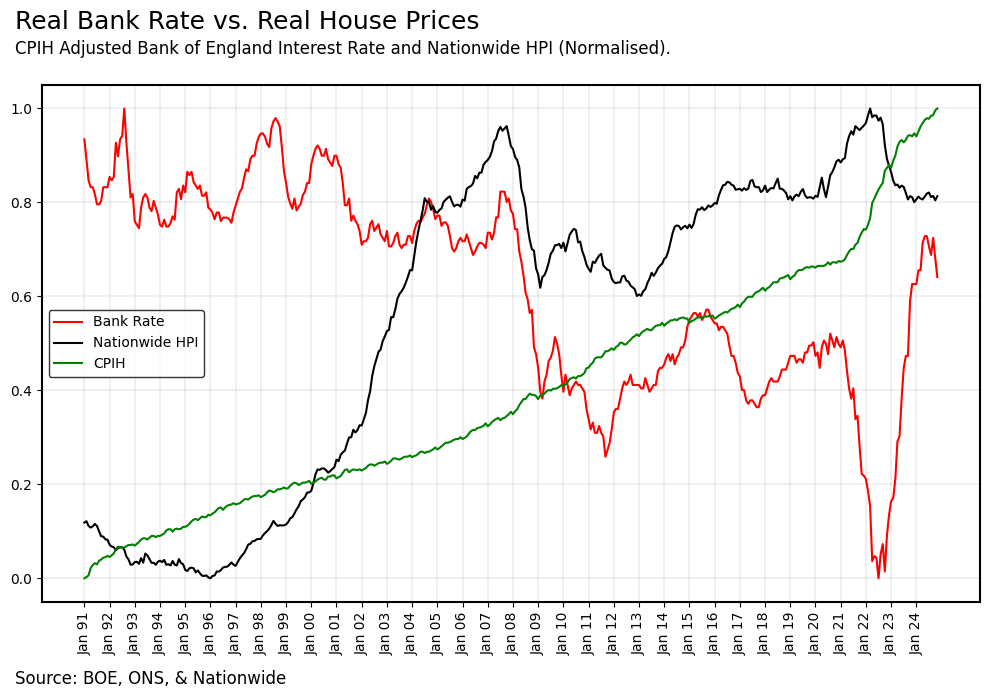

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor("white")

ax.plot(merged_df["Month_Year"], merged_df["Rate"], color="red", label="Bank Rate")

ax.plot(
    merged_df["Month_Year"], merged_df["Price"], color="black", label="Nationwide HPI"
)

ax.plot(merged_df["Month_Year"], merged_df["CPIH"], color="green", label="CPIH")


ax.grid(True, color="grey", linestyle="--", linewidth=0.25)
xticks = merged_df["Month_Year"][::12]  # every nth date
plt.xticks(xticks, rotation=90)

for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.02,
    0,
    "Source: BOE, ONS, & Nationwide",
    ha="left",
    va="top",
    fontsize=12,
    color="black",
)

if mode in ("CPIH", "RPI"):
    title = "Real Bank Rate vs. Real House Prices"
else:
    title = "Nominal Bank Rate vs. Nominal House Prices"
fig.text(
    0.02,
    1.1,
    title,
    ha="left",
    va="top",
    fontsize=18,
    color="black",
)

title = "Bank of England Interest Rate and Nationwide HPI (Normalised)."
if mode == "CPIH" or "RPI":
    title = f"{mode} Adjusted {title}"
fig.text(
    0.02,
    1.05,
    title,
    ha="left",
    va="top",
    fontsize=12,
    color="black",
)

# Nationwide HPI (% of Maximum)

# single legend
# handles, labels = ax.get_legend_handles_labels()
# handles2, labels2 = ax2.get_legend_handles_labels()
# handles.extend(handles2)
# labels.extend(labels2)
# fig.legend(handles, labels, loc="lower left", bbox_to_anchor=(0.6, 0.85))
plt.legend(facecolor="white", edgecolor="black", fontsize=10)

plt.tight_layout()

filename = os.path.join(PLOT_DIR, "rate.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

          Price
Price  1.000000
RPI    0.778637
CPIHA -0.011375
Rate  -0.696084
CPIH   0.794001
RPIA   0.220631
Wage   0.876745
(7, 1)


<Axes: >

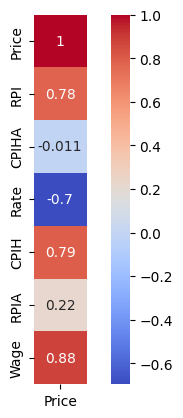

In [43]:
merged_df["Wage"] = pd.to_numeric(merged_df["Wage"], errors="coerce")

numerical_df = merged_df.select_dtypes(include=["number"])

correlation_matrix = numerical_df.corr()["Price"].to_frame()


print(correlation_matrix)

print(correlation_matrix.shape)


sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)

## Plot HPI & Mortgage Borrowing

In [44]:
def plot_hpi(start_date: str, data: dict[str, pd.DataFrame], xfreq: int) -> None:
    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(5, 1, height_ratios=[10, 2, 2, 2, 2], hspace=0)

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax3 = fig.add_subplot(gs[2], sharex=ax1)
    ax4 = fig.add_subplot(gs[3], sharex=ax1)
    ax5 = fig.add_subplot(gs[4], sharex=ax1)

    ax1.set_facecolor("white")
    max_df = None
    for label, df in data.items():
        df_filtered = df[df["Date"] >= start_date]
        ax1.plot(df_filtered["Month_Year"], df_filtered["Price"], label=label)
        if max_df is None or len(df_filtered) > len(max_df):
            max_df = df_filtered

    # Format y-axis for prices
    formatter = FuncFormatter(lambda x, p: f"£{x:,.0f}")
    ax1.yaxis.set_major_formatter(formatter)

    # Filter df_hmlr based on start_date
    df_hmlr_filtered = df_hmlr[df_hmlr["Date"] >= start_date]

    # Set up x-axis ticks using Month_Year values
    xtick_positions = max_df["Month_Year"][::xfreq]

    # Apply to all axes
    ax1.set_xticks(xtick_positions)
    # No labels for upper plots
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xticklabels([])

    # Style first plot
    ax1.grid(True, color="grey", linestyle="--", linewidth=0.25)
    ax1.legend(facecolor="white", edgecolor="black", fontsize=10)
    for spine in ax1.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1.5)

    # Add text annotations
    fig.text(
        0.02,
        0,
        "Source: BoE, ONS, HMLR, Halifax, Nationwide, Rightmove, & Zoopla.",
        ha="left",
        va="top",
        fontsize=12,
        color="black",
    )
    fig.text(
        0.02,
        1.1,
        "UK House Price Indices & Economic Indicators",
        ha="left",
        va="top",
        fontsize=18,
        color="black",
    )
    fig.text(
        0.02,
        1.05,
        "(1) House prices & mortgage values. (2) Percent of transactions cash."
        "\n(3) Number of mortgage approvals. (4) Unemployment rate. (5) BOE Rate.",
        ha="left",
        va="top",
        fontsize=12,
        color="black",
    )

    # Plot second axis using the same Month_Year values
    ax2.plot(
        df_hmlr_filtered["Month_Year"], df_hmlr_filtered["Percent_Cash"], color="black"
    )
    ax2.set_ylabel("% Cash")
    ax2.grid(True, color="grey", linestyle="--", linewidth=0.25)

    # Plot third axis
    df_mort_filtered = df_mort[df_mort["Date"] >= start_date]

    color = "black"
    alpha = 0.3
    # Create the filled area
    ax3.fill_between(
        df_mort_filtered["Month_Year"],
        df_mort_filtered["Number"],
        color=color,
        alpha=alpha,
    )

    # Make the line a darker version of the fill color
    line_color = plt.get_cmap("Greys")(0.8)

    ax3.plot(
        df_mort_filtered["Month_Year"],
        df_mort_filtered["Number"],
        color=line_color,
        linewidth=2,
    )

    ax3.set_ylabel("# Approvals")
    ax3.grid(True, color="grey", linestyle="--", linewidth=0.25)

    # Plot fourth axis
    df_unemp_filtered = df_unemp[df_unemp["Date"] >= start_date]

    ax4.plot(
        df_unemp_filtered["Month_Year"],
        df_unemp_filtered["Unemployment"],
        color="black",
    )
    ax4.set_ylabel("% Unemp")
    ax4.grid(True, color="grey", linestyle="--", linewidth=0.25)

    # Plot fifth axis
    df_rate_filtered = df_rate[df_rate["Date"] >= start_date]

    ax5.plot(df_rate_filtered["Month_Year"], df_rate_filtered["Rate"], color="black")
    ax5.set_ylabel("BOE")
    ax5.grid(True, color="grey", linestyle="--", linewidth=0.25)

    # Set x-ticks for bottom plot only
    ax5.set_xticks(xtick_positions)
    ax5.set_xticklabels(xtick_positions, rotation=90, ha="center")

    # Style all subplots
    for ax in [ax2, ax3, ax4]:
        for spine in ax.spines.values():
            spine.set_edgecolor("black")
            spine.set_linewidth(1.5)

    plt.tight_layout()

    filename = os.path.join(PLOT_DIR, f"house_prices_{start_date}.png")
    plt.savefig(filename, dpi=300, bbox_inches="tight")

In [45]:
data: dict = {
    "BoE Average Value of Mortgages Approved": df_mort,
    "Nationwide House Price Index": df_nw,
    "Halifax House Price Index": df_hal,
    "Rightmove House Price Index": df_rm,
    "Zoopla House Price Index": df_zoo,
    "ONS House Price Index": df_ons_hpi,
}

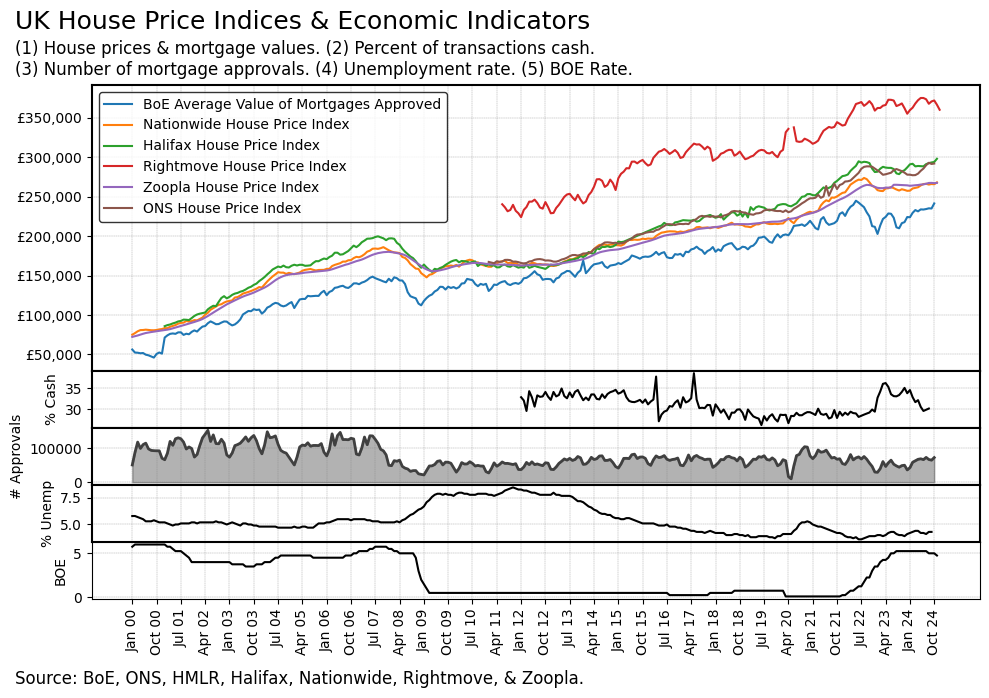

In [46]:
plot_hpi(start_date="2000-01-01", data=data, xfreq=9)

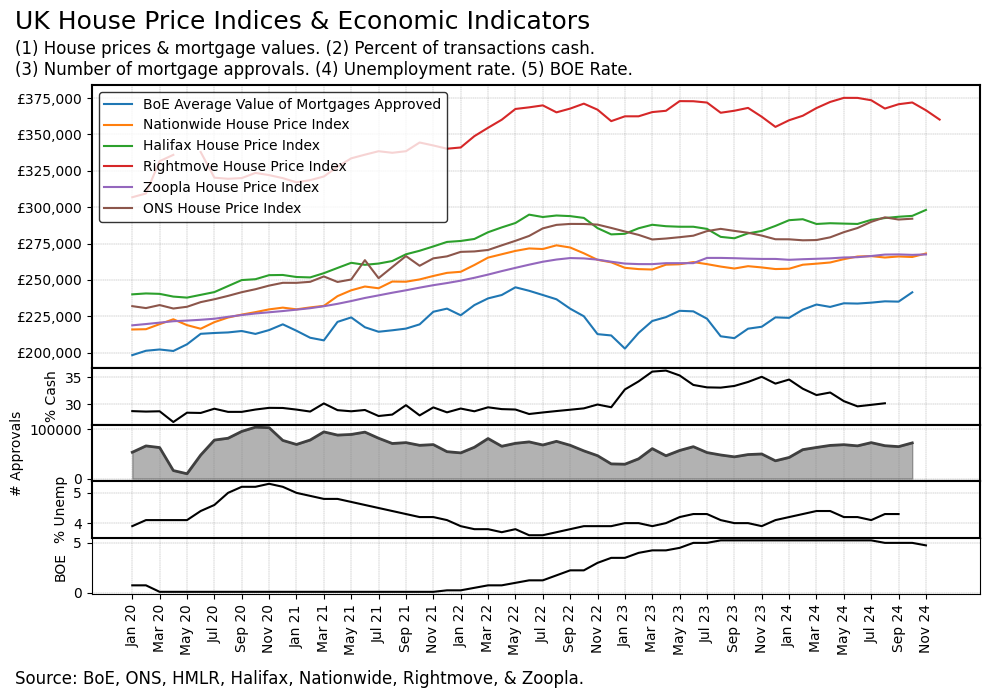

In [47]:
plot_hpi(start_date="2020-01-01", data=data, xfreq=2)